<a href="https://colab.research.google.com/github/SilvanaJ90/usergioarboleda-bootcamp_IA/blob/main/Red_neuronal_para_clasificador_de_ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
datos, metadatos = tfds.load('fashion_mnist',as_supervised=True, with_info=True)

In [ ]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

In [ ]:
datos_entrenamiento, datos_prueba = datos['train'], datos['test']

In [ ]:
nombre_clases = metadatos.features['label'].names

In [ ]:
nombre_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### **Normalizar los datos(Imagenes), esto pasar del rango 0-255 a el rango de 0-1**

In [ ]:
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255
  return imagenes, etiquetas

Cuando se dice que se normalizan los datos de las imágenes de un conjunto de datos, significa que se ajustan los valores de los píxeles en las imágenes para que estén dentro de un rango específico. En este caso, el rango objetivo es de 0 a 1.

Las imágenes digitales suelen representarse con valores de píxeles que van desde 0 (negro) hasta 255 (blanco) en una escala de grises o en cada canal de color (rojo, verde, azul) en una imagen en color. Normalizar los datos de la imagen implica dividir todos los valores de píxeles por 255 para reescalarlos al rango de 0 a 1.

Este proceso es común en el preprocesamiento de datos para el entrenamiento de modelos de aprendizaje automático, ya que puede ayudar a mejorar la convergencia del modelo y a evitar problemas numéricos, especialmente en algoritmos sensibles a la escala de los datos, como las redes neuronales.

In [ ]:
"""
Aplicación de la normalización a cada imagen por medio de mapeo.
"""
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

In [ ]:
datos_entrenamiento = datos_entrenamiento.cache()
datos_prueba = datos_prueba.cache()

### **Mostraremos algunos elementos del dataset**

In [ ]:
for image,etiqueta in datos_entrenamiento.take(1):
  break;

imagen = image.numpy().reshape((28,28))

In [ ]:
import matplotlib.pyplot as plt

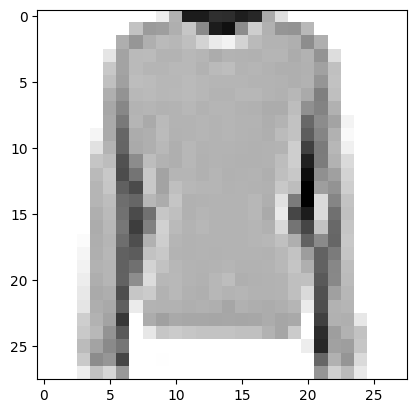

In [ ]:
plt.figure()
plt.imshow(imagen,cmap=plt.cm.binary)
plt.grid(False)
plt.show()

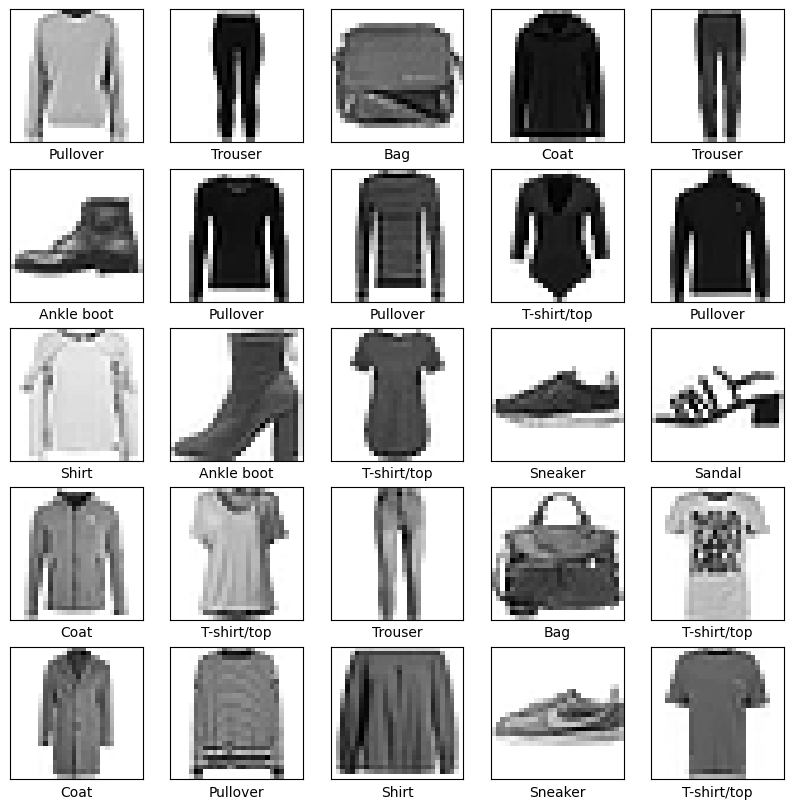

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen,cmap=plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])

### **Modelo clásico de red neuronal MLP**

In [ ]:
#modelo = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(28,28)),
#    tf.keras.layers.Dense(units=50,activation='relu'),
#    tf.keras.layers.Dense(units=50,activation='relu'),
#    tf.keras.layers.Dense(units=10,activation='softmax')
#])

### **Modelo Depp Learning**

In [ ]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), input_shape=(28,28,1),activation='relu'),  #crea una capa convolucional 2D, que toma como entrada un tensor tridimensional representando una imagen
    tf.keras.layers.MaxPooling2D(2,2),  #Después de cada capa de convolución, se sigue una capa de max-pooling. reduce la dimensionalidad de la imagen reduciendo el número de píxeles en las regiones de la imagen

    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    """
    Esta capa se utiliza para aplanar la salida de las capas convolucionales y de pooling, convirtiéndola en un tensor unidimensional
    para que pueda ser ingresado a las capas densas (totalmente conectadas).
    """
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=50,activation='relu'),

    tf.keras.layers.Dense(units=50,activation='relu'),
    tf.keras.layers.Dense(units=50,activation='relu'),
    """
     Tener múltiples capas densas después de la capa de aplanamiento en una CNN permite al modelo aprender representaciones más complejas y abstractas de los datos,
     lo que puede mejorar su capacidad para realizar tareas de clasificación o regresión en imágenes.
    """

    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [ ]:
modelo.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
num_datos_entrenamiento = metadatos.splits['train'].num_examples
num_datos_pruebas = metadatos.splits['test'].num_examples

print(num_datos_entrenamiento)
print(num_datos_pruebas)

60000
10000


In [ ]:
# número de muestras de datos que se utilizan en una iteración de entrenamiento. Usar lotes permite que el modelo actualice sus pesos
# de manera más eficiente y, a menudo, conduce a un entrenamiento más rápido y estable.
TAMANNO_BATCH = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANNO_BATCH)
datos_prueba = datos_prueba.batch(TAMANNO_BATCH)

In [ ]:
import math

In [ ]:
# inicia el proceso de entrenamiento del modelo utilizando los datos de entrenamiento proporcionados,
# realizando 7 épocas de entrenamiento y especificando el número de pasos (batches) por época.
historial = modelo.fit(datos_entrenamiento, epochs=7,steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANNO_BATCH))

Epoch 1/7
1875/1875 [==============================] - 20s 4ms/step - loss: 0.4973 - accuracy: 0.8172
Epoch 2/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3190 - accuracy: 0.8834
Epoch 3/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2766 - accuracy: 0.8992
Epoch 4/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2425 - accuracy: 0.9112
Epoch 5/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2192 - accuracy: 0.9194
Epoch 6/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2001 - accuracy: 0.9258
Epoch 7/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1849 - accuracy: 0.9322


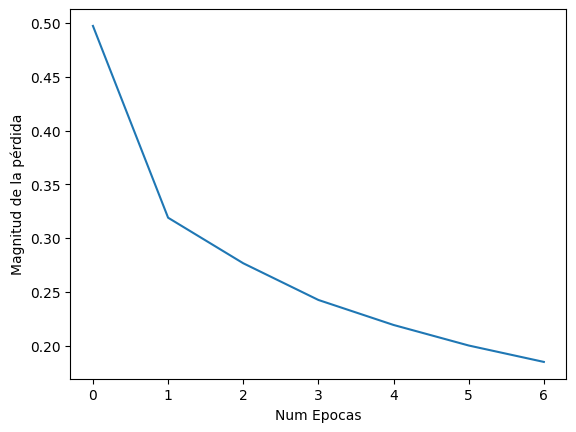

In [ ]:
plt.xlabel("Num Epocas")
plt.ylabel("Magnitud de la pérdida")
plt.plot(historial.history['loss'])

In [ ]:
import numpy as np

1/1 [==============================] - 0s 111ms/step


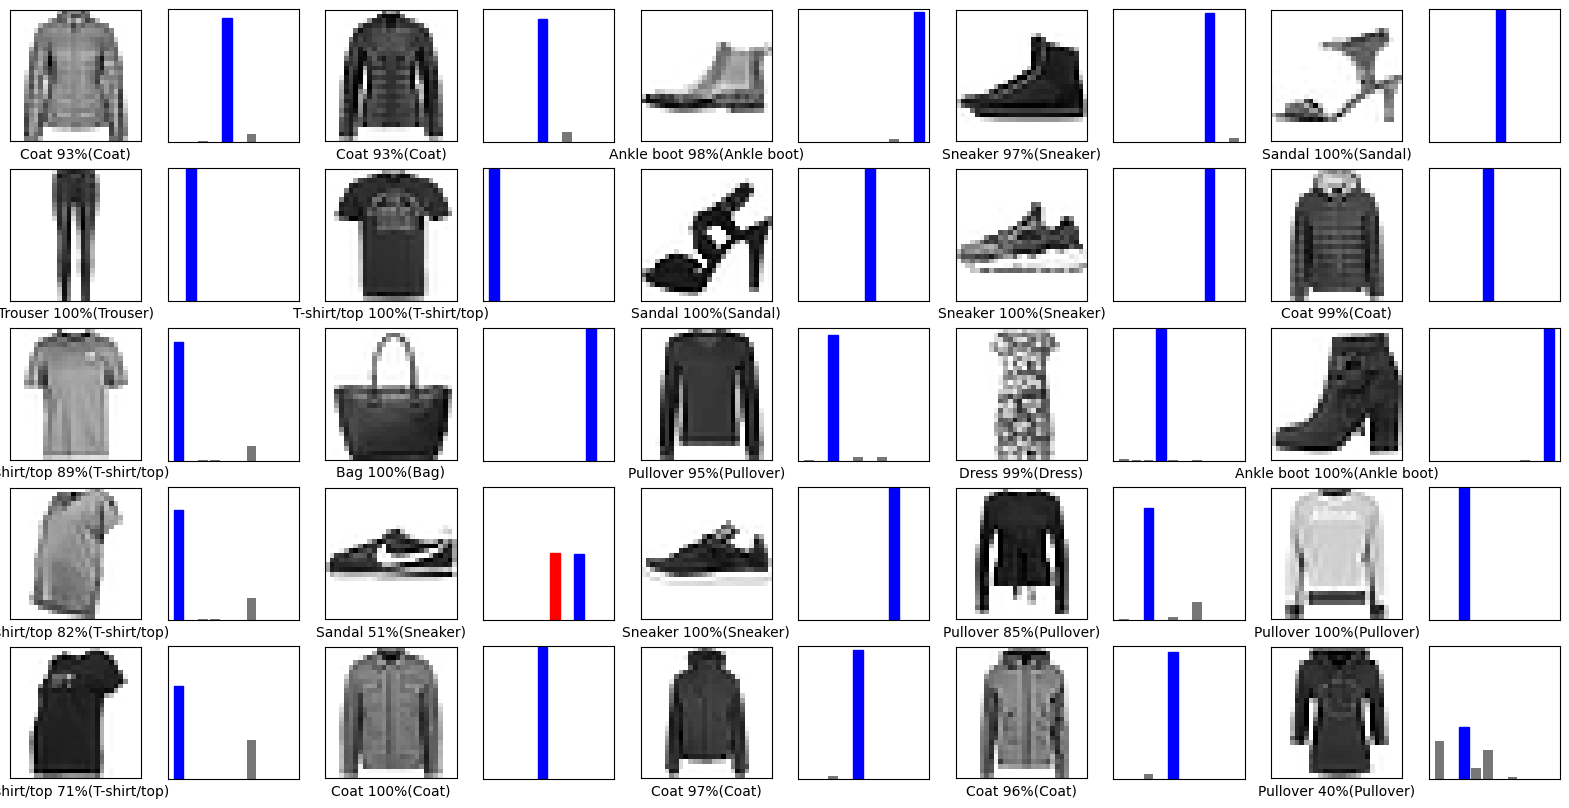

In [ ]:
for imagenes_prueba,etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba =  etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i,arr_predicciones, etiquetas_reales,imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue' # si le atinó
  else:
    color =  'red' # si se peló

  plt.xlabel("{} {:2.0f}%({})".format(nombre_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombre_clases[etiqueta_real],
      color = color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_reales):
    arr_prediccion, etiqueta_real = arr_predicciones[i], etiqueta_reales[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_prediccion, color='#777777')
    plt.ylim([0,1])
    etiqueta_prediccion = np.argmax(arr_prediccion)

    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

fil = 5
col = 5

num_imagenes=fil*col
plt.figure(figsize=(2*2*col,2*fil))
for i in range(num_imagenes):
  plt.subplot(fil,2*col, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba,imagenes_prueba)
  plt.subplot(fil,2*col, 2*i+2)
  graficar_valor_arreglo(i,predicciones,etiquetas_prueba)

### **Algo mas sencillo**

In [ ]:
imagen = imagenes_prueba[20]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)


print("Predicción " + nombre_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 19ms/step
Predicción T-shirt/top
